In [1]:
import glob
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import gsw

# S-MODE Data Workshop: in-situ data demo

This is a simple demo of a workflow for downloading and working with S-MODE in-situ data. We will work with underway data collected by saildrones and R/V Oceanus during the S-MODE Pilot Campaign.

If you have any questions, do not hesitate in contacting me (cesar.rocha@uconn.edu).

### Road map

1. Download saildrone data
2. Load and plot single dataset (one saildrone)
3. Load and merge multiple datasets (five saildrones)
4. Compare saildrone ADCP data with R/V Oceanus ADCP data

### First, download the saildrone data
The saildrone data are organized into two different sets of files: ADCP (velocity measurements) and NON-ADCP (everything else).

In [2]:
start_time = '2021-10-20T00:00:00Z'
end_time = '2021-11-08T00:00:00Z'
short_name = 'SMODE_LX_SAILDRONES_V1'
data_path = 'data/'

In [3]:
!podaac-data-downloader -c $short_name -d $data_path$short_name --start-date $start_time --end-date $end_time

/Users/crocha/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
[2022-11-28 15:12:41,852] {podaac_data_downloader.py:155} INFO - NOTE: Making new data directory at data/SMODE_LX_SAILDRONES_V1(This is the first run.)
[2022-11-28 15:12:42,530] {podaac_data_downloader.py:243} INFO - Found 10 total files to download
[2022-11-28 15:12:51,461] {podaac_data_downloader.py:276} INFO - 2022-11-28 15:12:51.461018 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMODE_LX_SAILDRONES_V1/SMODE_PFC_saildrone_adcp_1074.nc
[2022-11-28 15:12:55,031] {podaac_data_downloader.py:276} INFO - 2022-11-28 15:12:55.031637 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMODE_LX_SAILDRONES_V1/SMODE_PFC_saildrone_adcp_

### Non-ADCP data

##### Single saildrone

In [4]:
ds = xr.open_dataset(data_path + short_name + '/SMODE_PFC_saildrone_nonadcp_1073.nc').isel(trajectory=0)

In [5]:
ds

<xarray.Dataset>
Dimensions:                         (obs: 27360)
Coordinates:
    latitude                        (obs) float64 ...
    longitude                       (obs) float64 ...
    time                            (obs) datetime64[ns] ...
    trajectory                      float32 1.073e+03
Dimensions without coordinates: obs
Data variables: (12/76)
    SOG                             (obs) float64 ...
    SOG_FILTERED_MEAN               (obs) float64 ...
    SOG_FILTERED_STDDEV             (obs) float64 ...
    SOG_FILTERED_MAX                (obs) float64 ...
    SOG_FILTERED_MIN                (obs) float64 ...
    COG                             (obs) float64 ...
    ...                              ...
    BKSCT_RED_STDDEV                (obs) float64 ...
    WATER_CURRENT_SPEED_MEAN        (obs) float64 ...
    WATER_CURRENT_DIRECTION_MEAN    (obs) float64 ...
    corrected_backscatter_at_650nm  (obs) float64 ...
    particulate_organic_carbon      (obs) float64 ...
    calibrated_chlorophyll          (obs) float64 ...
Attributes: (12/64)
    title:                         S-MODE Pilot Campaign Fall 2021 Temperatur...
    summary:                       1min surface metereological and oceanograp...
    ncei_template_version:         NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:                   CF-1.8, ACDD-1.3
    netcdf_version:                4.6.3
    featureType:                   trajectory
    ...                            ...
    acknowledgement:               We thank Paban Bhuyan (UConn) and Kim Spar...
    time_coverage_start:           2021-10-19T00:00:00Z
    time_coverage_end:             2021-11-06T23:59:00Z
    geospatial_lon_min:            -125.57976388888889
    geospatial_lon_max:            -122.39241944444444
    id:                            SMODE_LX_SAILDRONES_V1

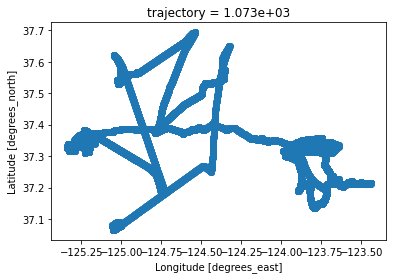

In [6]:
ds.plot.scatter(x='longitude',y='latitude')

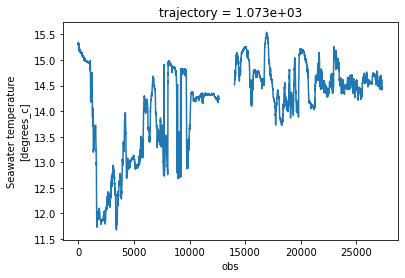

In [7]:
# plot data
ds.TEMP_SBE37_MEAN.plot()

Text(0.5, 0, '')

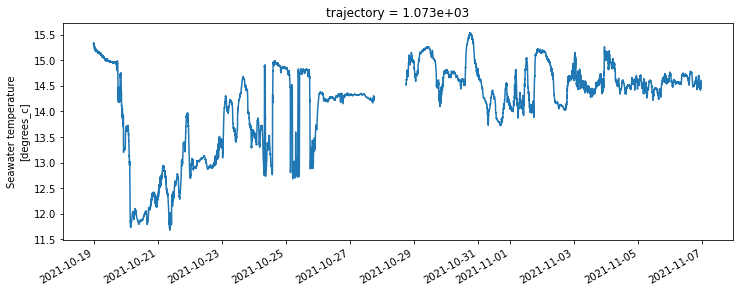

In [8]:
# plot data as a timeseries
fig, ax = plt.subplots(figsize=(12,4))
ds.TEMP_SBE37_MEAN.plot(x='time',ax=ax)
ax.set_xlabel('')

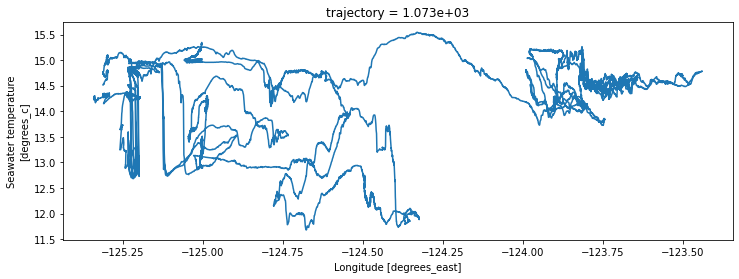

In [9]:
# plot dat as a function of longitude
fig, ax = plt.subplots(figsize=(12,4))
ds.TEMP_SBE37_MEAN.plot(x='longitude',ax=ax)

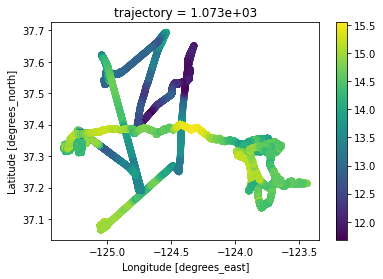

In [10]:
im = ds.plot.scatter(x='longitude',y='latitude',c=ds.TEMP_SBE37_MEAN)
plt.colorbar(im)

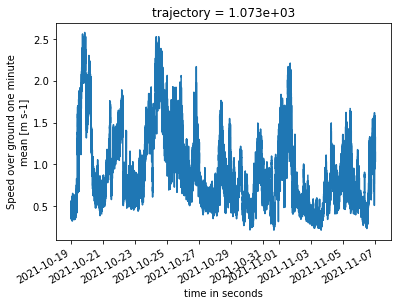

In [11]:
ds.SOG_FILTERED_MEAN.plot(x='time')

#### Example: calculate density, a derived quantitty

In [12]:
ds['sigma0'] = gsw.sigma0(ds.SAL_SBE37_MEAN,ds.TEMP_SBE37_MEAN)

# ds.sigma0.attrs['standard_name'] = 'sea_water_potential_density'
# ds.sigma0.attrs['long_name'] = 'Seawater potential density'
# ds.sigma0.attrs['units'] = 'kg m^{-3}'


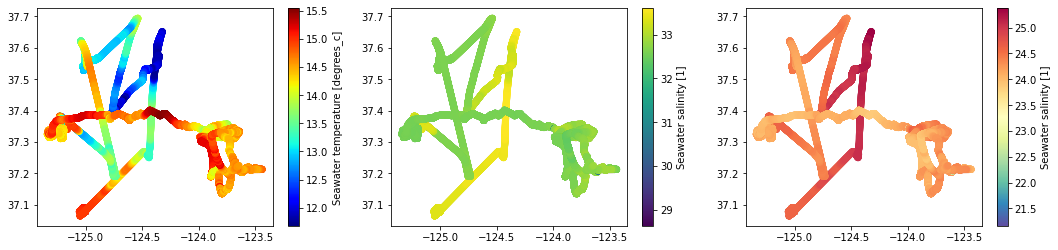

In [13]:
# Now plot temperature, salinity and density
fig, axs = plt.subplots(1,3,figsize=(18,4))

variables = [
    ds.TEMP_SBE37_MEAN, 
    ds.SAL_SBE37_MEAN, 
    ds.sigma0
]

cmaps = ['jet', 'viridis','Spectral_r']

for  ax, var, cmap in zip(axs, variables, cmaps):

    im = ax.scatter(ds.longitude,ds.latitude,c=var,cmap=cmap)
    fig.colorbar(im,ax=ax,label=var.attrs['long_name'] + ' [' + var.attrs['units'] + ']')

### All saildrones
Oftentimes it is conveninent to have all saildrone data in a single dataset for easy manipulation and comparisons.

In [14]:
files = glob.glob(data_path + short_name + '/*_nonadcp_*')

drop_vars = ['TEMP_DEPTH_HALFMETER_MEAN',
             'TEMP_DEPTH_HALFMETER_STDDEV',
             'corrected_backscatter_at_650nm',
             'particulate_organic_carbon',
             'calibrated_chlorophyll'
            ]

# loop through files (i.e., different saildrones),
# open dataset, drop variables not available for all
# saildrones and concatenate datasets along the trajectory
# dimension

for file in files:

    foo = xr.open_dataset(file)
    
    for drop_var in drop_vars:
        if drop_var in foo.variables:
            foo = foo.drop(drop_var)
    
    foo = foo.isel(trajectory=0).swap_dims(
        {'obs':'time'}
    ).expand_dims('trajectory')

    if file == files[0]:
        nonadcp = foo
    else:
        nonadcp = xr.concat([nonadcp,foo],dim='trajectory')

In [15]:
# single saildrone dataset is a subset of nonadcp dataset
nonadcp73 = nonadcp.sel(trajectory=1073.)

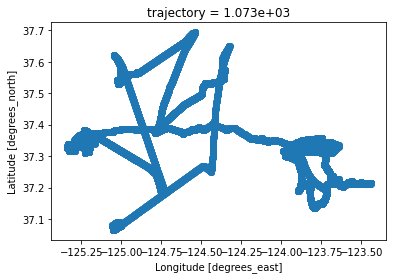

In [16]:
nonadcp73.plot.scatter(x='longitude',y='latitude')

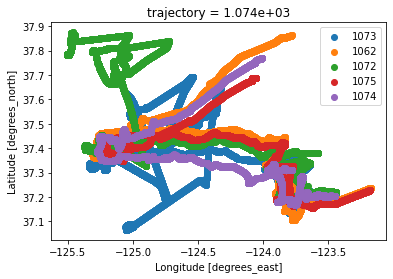

In [17]:
# plot all trajectories
for sd in nonadcp.trajectory:
    nonadcp.sel(trajectory=sd).plot.scatter(x='longitude',y='latitude',label=int(sd.values))
    
plt.legend()

### ADCP data

##### Single file: saildrone 1072

In [18]:
adcp72 = xr.open_dataset(data_path + short_name + '/SMODE_PFC_saildrone_adcp_1072.nc').isel(trajectory=0)
adcp73 = xr.open_dataset(data_path + short_name + '/SMODE_PFC_saildrone_adcp_1073.nc').isel(trajectory=0)

In [19]:
# Slice the data in time, assigning a 3-day subset

# virtual mooring
# t0 = np.datetime64('2021-11-23T12')
# t1 = np.datetime64('2021-11-28T12')

# formation sailing
# t0 = np.datetime64('2021-11-01T04')
# t1 = np.datetime64('2021-11-01T18')

# comparison with oceanus
t0 = np.datetime64('2021-11-06T16')
t1 = np.datetime64('2021-11-06T20')

subset72 = adcp72.where((adcp72.time>=t0)&(adcp72.time<=t1),drop=True) 
subset73 = adcp73.where((adcp73.time>=t0)&(adcp73.time<=t1),drop=True) 

(37.21, 37.23)

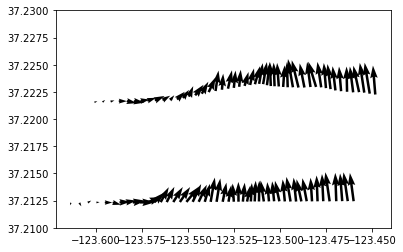

In [20]:
depth_bin = 2

for subset in [subset72,subset73]:

    plt.quiver(
        subset.longitude,
        subset.latitude,
        subset.vel_east.isel(cell_depth=depth_bin),
        subset.vel_north.isel(cell_depth=depth_bin)
    )

plt.ylim(37.21,37.23)

[(80.0, 0.0), (80.0, 0.0)]

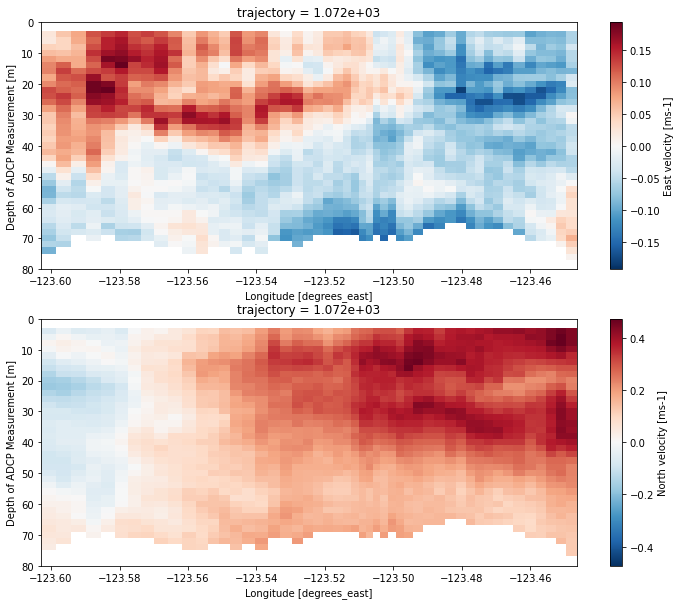

In [21]:
# Example: vertical sections
fig, axs = plt.subplots(2,1, figsize=(12,10))
subset72.vel_east.where(subset72.percent_good>90).plot(x='longitude',y='cell_depth',ax=axs[0])
subset72.vel_north.where(subset72.percent_good>90).plot(x='longitude',y='cell_depth',ax=axs[1])
[ax.set_ylim(80,0) for ax in axs]

(18937.666666666668, 18937.833333333332)

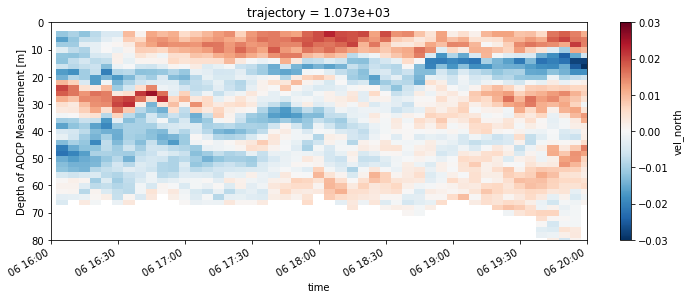

In [22]:
# Example: calculate and plot vertical shear
fig, ax = plt.subplots(figsize=(12,4))
kw = {'vmin': -0.03,'vmax': 0.03,'cmap': 'RdBu_r'}

subset.vel_north.differentiate('cell_depth').where(subset.percent_good>95).plot(x='time',**kw)

plt.ylim(80,0)
plt.xlim(t0,t1)

## Compare saildrone ADCP data with R/V Oceanus data

A major goal of the S-MODE Pilot was to compare saildrone ADCP data. Here's one example of a simple saildrone-Oceanus velocity comparison.

In [23]:
# this is not working for the Oceanus ADCP
start_time = '2021-10-20T00:00:00Z'
start_time = '2021-08-01T00:00:00Z'
end_time = '2021-11-08T00:00:00Z'

short_name = 'SMODE_LX_SHIPBOARD_ADCP_V1'
!podaac-data-downloader -c $short_name -d data/$short_name --start-date $start_time --end-date $end_time -e .nc4

/Users/crocha/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
[2022-11-28 15:13:35,311] {podaac_data_downloader.py:155} INFO - NOTE: Making new data directory at data/SMODE_LX_SHIPBOARD_ADCP_V1(This is the first run.)
[2022-11-28 15:13:35,835] {podaac_data_downloader.py:243} INFO - Found 2 total files to download
[2022-11-28 15:13:41,382] {podaac_data_downloader.py:276} INFO - 2022-11-28 15:13:41.382757 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMODE_LX_SHIPBOARD_ADCP_V1/S-MODE_PFC_OC2108A_adcp_os75nb.nc4
[2022-11-28 15:13:47,788] {podaac_data_downloader.py:276} INFO - 2022-11-28 15:13:47.787959 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMODE_LX_SHIPBOARD_ADCP_V1/S-MODE_PFC_O

In [24]:
ds = xr.open_dataset('data/SMODE_LX_SHIPBOARD_ADCP_V1/S-MODE_PFC_OC2108A_adcp_wh300.nc4',drop_variables='depth').isel(trajectory=0)
ds['depth'] =  Dataset('data/SMODE_LX_SHIPBOARD_ADCP_V1/S-MODE_PFC_OC2108A_adcp_wh300.nc4')['depth'][0]

In [25]:
subset_oceanus = ds.where((ds.time>=t0)&(ds.time<=t1),drop=True) 

In [26]:
# interpolate to subset72 time
# TODO: try to resample with averaging to 5 minutes before interpolating (e.g.,  subset_oceanus.resample(time='5min').mean())
subset_oceanus = subset_oceanus.interp({'time': subset72.time})

/Users/crocha/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/crocha/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


In [27]:
# interpolate to saildrone depth to oceanus depth
subset72['depth'] = subset72.cell_depth + 1.9  # add depth of the instrument 1.9
subset72 = subset72.swap_dims({'cell_depth': 'depth'})
subset72 = subset72.interp({'depth': subset_oceanus.depth})

/Users/crocha/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/crocha/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


#### Visual comparison

(37.22, 37.235)

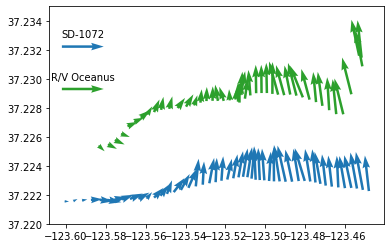

In [28]:
depth_bin = 1

sc = 4

q1 = plt.quiver(
        subset72.longitude,
        subset72.latitude,
        subset72.vel_east.isel(depth=depth_bin),
        subset72.vel_north.isel(depth=depth_bin),
        color='C00',scale=sc
)


q2 = plt.quiver(
        subset_oceanus.longitude,
        subset_oceanus.latitude,
        subset_oceanus.zonal_velocity_component.isel(depth=depth_bin),
        subset_oceanus.meridional_velocity_component.isel(depth=depth_bin),
        color='C02', scale=sc
)

plt.quiverkey(q1, .1, 0.815, .5, 'SD-1072',)
plt.quiverkey(q2, .1, 0.620, .5, 'R/V Oceanus',)

plt.ylim(37.22,37.235)

[(80.0, 0.0), (80.0, 0.0)]

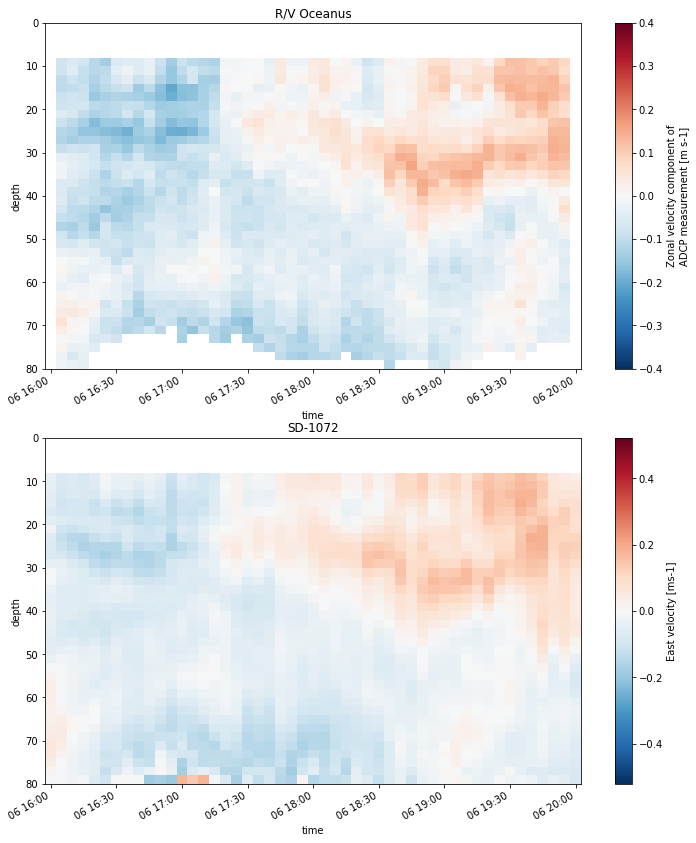

In [29]:
fig, axs = plt.subplots(2,1,figsize=(12,14))

kw = {'vmin': -.4,'vmax': +.4,'cmap': 'RdBu_r'}

subset_oceanus.zonal_velocity_component.plot(x='time',y='depth',ax=axs[0],**kw)
subset72.vel_east.plot(x='time',y='depth',ax=axs[1])

axs[0].set_title('R/V Oceanus')
axs[1].set_title('SD-1072')

[ax.set_ylim(80,0) for ax in axs]

#### Quantitative comparison: calculate and plot differences

In [30]:
subset_oceanus = subset_oceanus.where(subset_oceanus.depth<=70)
subset72 =  subset72.where(subset_oceanus.depth<=70)

In [31]:
du = subset_oceanus.zonal_velocity_component-subset72.vel_east
dv = subset_oceanus.meridional_velocity_component-subset72.vel_north

(array([  1.,   4.,   2.,   3.,   5.,  11.,  18.,  20.,  38.,  57.,  71.,
         74.,  97.,  96., 123., 130., 122., 124.,  87.,  80.,  78.,  76.,
         46.,  35.,  28.,  13.,   6.,   5.,   1.,   1.]),
 array([-1.50000000e-01, -1.40000000e-01, -1.30000000e-01, -1.20000000e-01,
        -1.10000000e-01, -1.00000000e-01, -9.00000000e-02, -8.00000000e-02,
        -7.00000000e-02, -6.00000000e-02, -5.00000000e-02, -4.00000000e-02,
        -3.00000000e-02, -2.00000000e-02, -1.00000000e-02,  1.38777878e-16,
         1.00000000e-02,  2.00000000e-02,  3.00000000e-02,  4.00000000e-02,
         5.00000000e-02,  6.00000000e-02,  7.00000000e-02,  8.00000000e-02,
         9.00000000e-02,  1.00000000e-01,  1.10000000e-01,  1.20000000e-01,
         1.30000000e-01,  1.40000000e-01,  1.50000000e-01]),
 <BarContainer object of 30 artists>)

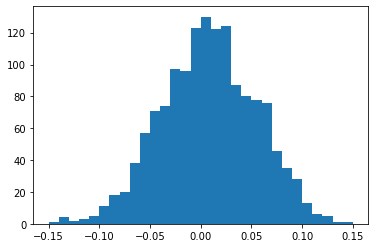

In [32]:
plt.hist(dv.values.flatten(),bins=np.arange(-.15,.156,.01))

In [118]:
du.std(), dv.std()

(<xarray.DataArray ()>
 array(0.03616049)
 Coordinates:
     trajectory  float64 -1.635e+09,
 <xarray.DataArray ()>
 array(0.04748247)
 Coordinates:
     trajectory  float64 -1.635e+09)